In [1]:
library(tidyverse)
library(cowplot)
library(ggrepel)
library(pROC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [140]:
`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

In [2]:
full_auroc_df <- read_csv('hetionet_auroc.csv')

full_auroc_df %>% head(2)

Parsed with column specification:
cols(
  metaedge = col_character(),
  network = col_character(),
  xswap_auc = col_double(),
  analytic_auc = col_double(),
  degree_product_auc = col_double(),
  xswap_analytic_pearson = col_double(),
  xswap_degree_pearson = col_double(),
  analytic_degree_pearson = col_double(),
  xswap_analytic_spearman = col_double(),
  xswap_degree_spearman = col_double(),
  analytic_degree_spearman = col_double(),
  xswap_mae = col_double(),
  analytic_mae = col_double(),
  degree_mae = col_double()
)


metaedge,network,xswap_auc,analytic_auc,degree_product_auc,xswap_analytic_pearson,xswap_degree_pearson,analytic_degree_pearson,xswap_analytic_spearman,xswap_degree_spearman,analytic_degree_spearman,xswap_mae,analytic_mae,degree_mae
AdG,Original,0.9893888,0.9891555,0.9891437,0.9888247,0.989314,0.9812317,0.9999947,0.9999937,0.9999998,0.016102612,0.015863588,1241.455
AdG,Sample_50,0.9453517,0.9452759,0.9452496,0.9963539,0.998329,0.9937833,0.9999994,0.9999992,0.9999998,0.009741119,0.009589568,2635646.269


## Original vs Sampled trend by feature

In [3]:
compare_features_trend <- full_auroc_df %>%
    gather('feature', 'auc', ends_with('auc')) %>%
    mutate(
        network = network %>% recode_factor(Original = 'Original', Sample_50 = '50%', 
                                            Sample_20 = '20%'),
        feature = feature %>% recode_factor(xswap_auc = "XSwap", analytic_auc = "Analytic",
                                            degree_product_auc = "Degree")
    )

compare_features_trend %>% head(2)

metaedge,network,xswap_analytic_pearson,xswap_degree_pearson,analytic_degree_pearson,xswap_analytic_spearman,xswap_degree_spearman,analytic_degree_spearman,xswap_mae,analytic_mae,degree_mae,feature,auc
AdG,Original,0.9888247,0.989314,0.9812317,0.9999947,0.9999937,0.9999998,0.016102612,0.015863588,1241.455,XSwap,0.9893888
AdG,50%,0.9963539,0.998329,0.9937833,0.9999994,0.9999992,0.9999998,0.009741119,0.009589568,2635646.269,XSwap,0.9453517


In [173]:
options(repr.plot.width=10, repr.plot.height=4)

trend_line_across_network <- (
    ggplot(compare_features_trend, aes(x = network, y = auc, group = metaedge, label = metaedge))
    + geom_point()
    + geom_line()
    + geom_label_repel(
        data = compare_features_trend %>%
            group_by(feature) %>%
            filter(network == 'Original') %>%
            top_n(2, wt = auc),
        nudge_x = 1
    )
    + facet_grid(cols = vars(feature))
    + ylim(0.5, 1)
    + ylab('AUROC')
    + theme_zietzm()
)

## Compare features within each network

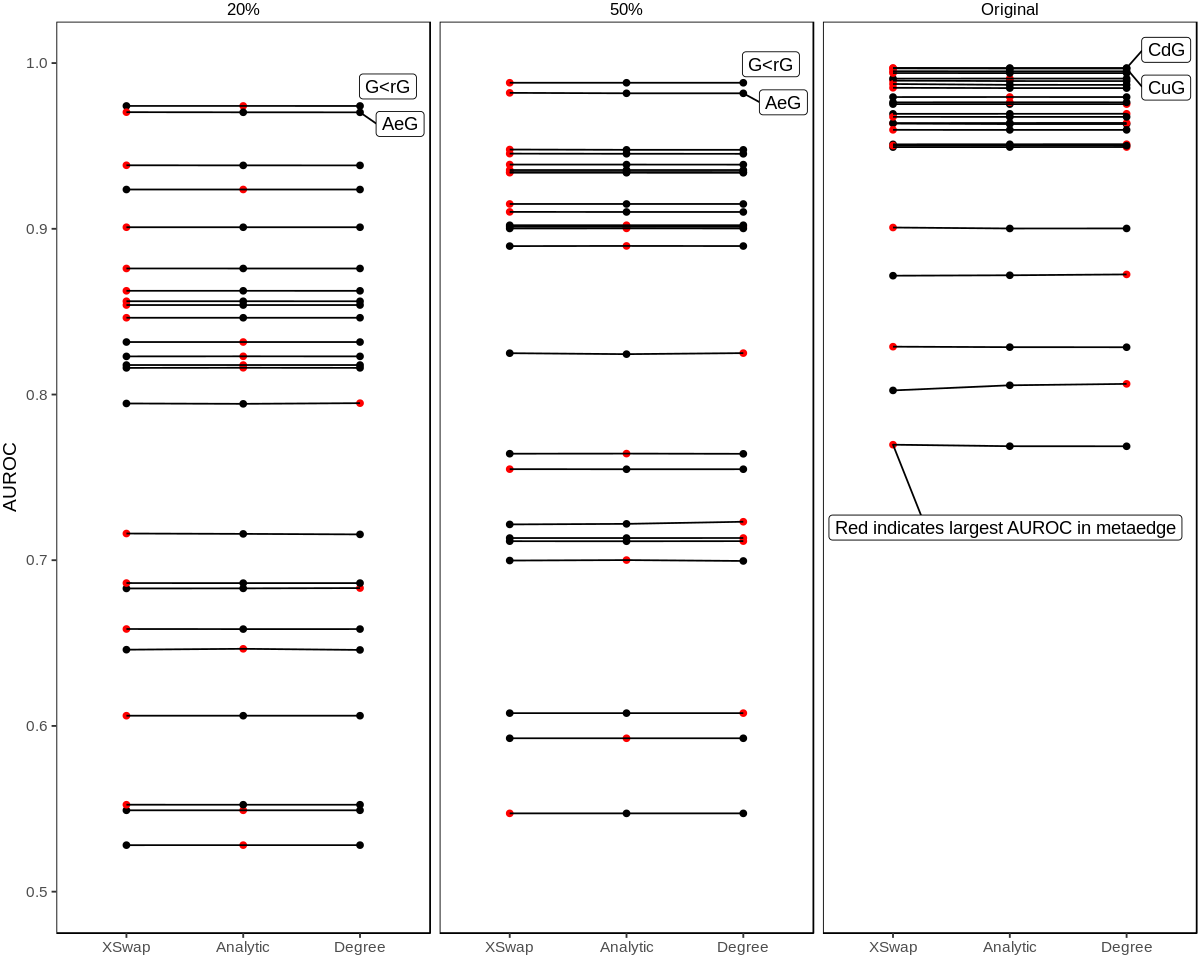

In [239]:
trend_line_across_feature + geom_label_repel(
    data = compare_features_trend %>%
        filter(network == 'Original', feature == 'XSwap') %>%
        top_n(n = 1, wt = -auc), 
    label = "Red indicates largest AUROC in metaedge", nudge_y = -0.05)

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

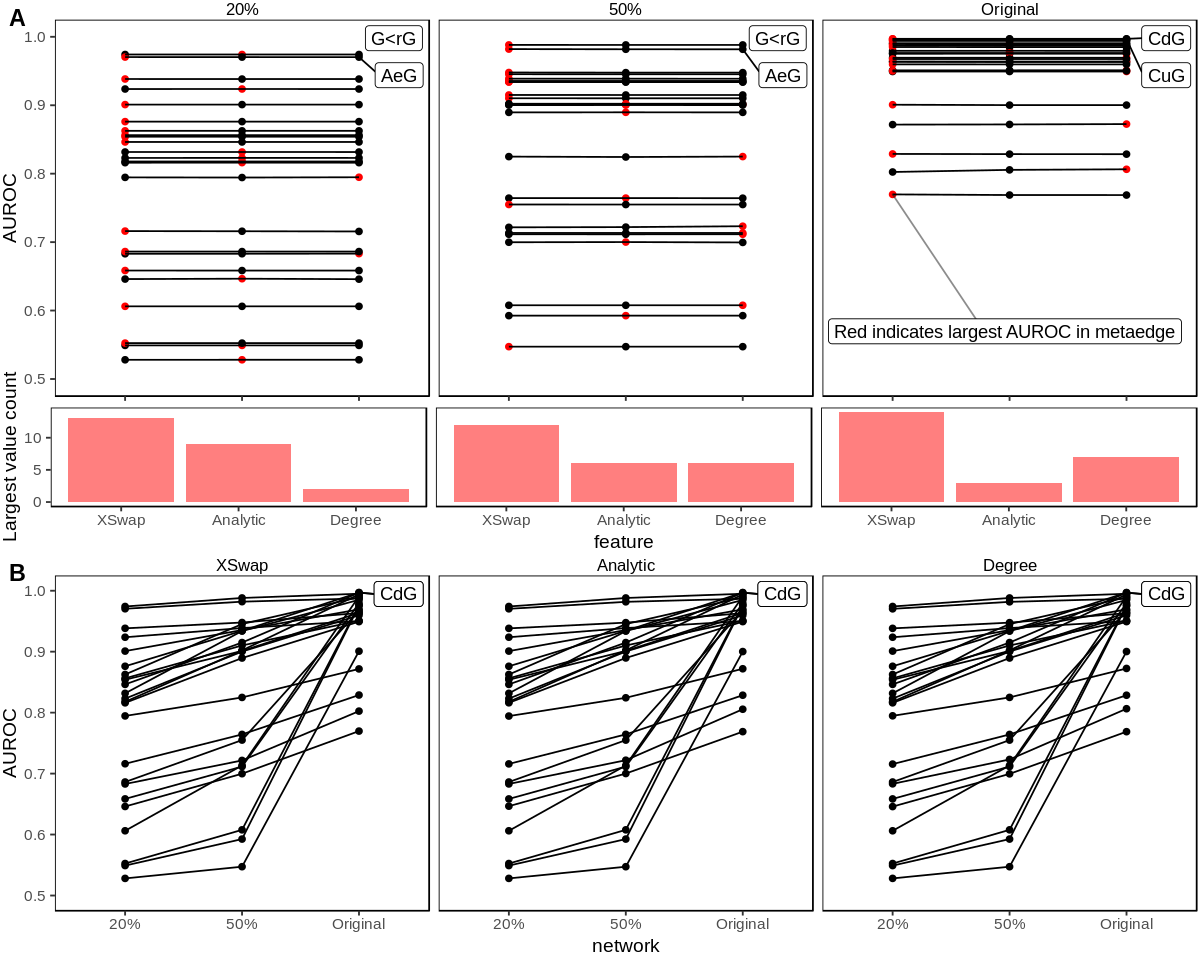

In [266]:
compare_features_trend <- compare_features_trend %>% 
    group_by(metaedge, network) %>%
    mutate(
        largest = (auc == max(auc)),
    ) %>%
    ungroup() %>%
    mutate(network = network %>% factor(levels = c("20%", "50%", "Original")))


selected_labels_df <- bind_rows(
    compare_features_trend %>%
        filter(feature == 'Degree') %>%
        group_by(network) %>%
        top_n(n = 2, wt = auc)
)

options(repr.plot.width=10, repr.plot.height=8)

trend_line_across_feature <- (
   ggplot(compare_features_trend, aes(x = feature, y = auc, group = metaedge, label = metaedge))
    + geom_point(aes(color = factor(largest)))
    + geom_line()
    + geom_label_repel(data = selected_labels_df, nudge_x = 2)
    + geom_label_repel(
        data = compare_features_trend %>%
            filter(network == 'Original', feature == 'XSwap') %>%
            top_n(n = 1, wt = -auc), 
        label = "Red indicates largest AUROC in metaedge", nudge_y = -0.2, segment.colour = "grey10",
        segment.alpha = 0.5)
    + facet_grid(cols = vars(network))
    + ylim(0.5, 1) 
    + ylab('AUROC')
    + scale_color_manual(name = 'Highest feature', values = c('TRUE' = 'red', 'FALSE' = 'black'))
    + theme_zietzm()
    + theme(legend.position = "none", axis.title.x = element_blank(), axis.text.x = element_blank())
)

histogram <- (
    ggplot(data = compare_features_trend %>% 
           filter(largest == T), 
           aes(x = feature))
    + geom_histogram(stat = 'count', fill = 'red', alpha = 0.5)
    + facet_grid(cols = vars(network))
    + ylab('Largest value count')
    + theme_zietzm()
    + theme(strip.text.x = element_blank())
)

plot_grid(trend_line_across_feature, histogram, trend_line_across_network, ncol = 1,
          rel_heights = c(2, 0.75, 2), labels = c("A", "", "B"))

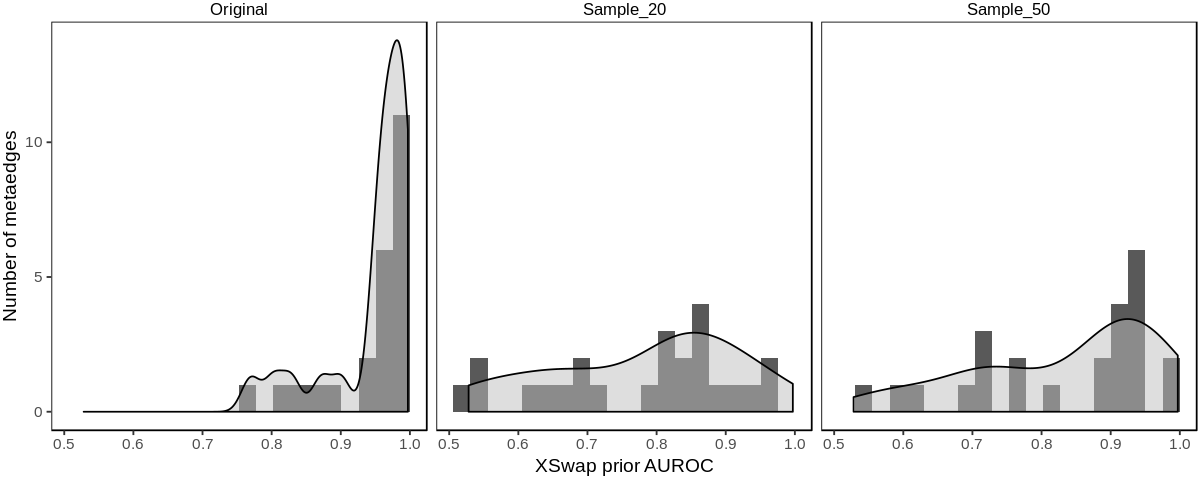

In [155]:
options(repr.plot.width=10, repr.plot.height=4)

(
    ggplot(full_auroc_df, aes(x = xswap_auc))
    + geom_histogram(bins = 20)
    + geom_density(fill = 'grey', alpha = 0.5)
    + facet_wrap('network')
    + ylab('Number of metaedges')
    + xlab('XSwap prior AUROC')
    + theme_zietzm()
)

## Correlations

metaedge,network,feature,auc,mae
AdG,Original,xswap,0.9893888,0.016102612
AdG,Sample_50,xswap,0.9453517,0.009741119


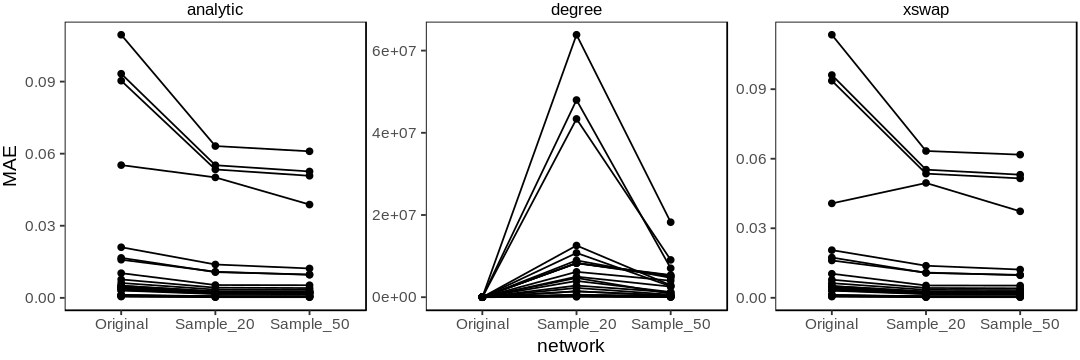

In [159]:
mae_histogram <- full_auroc_df %>%
    select(metaedge, network, ends_with('auc'), ends_with('mae')) %>%
    unite('xswap', xswap_auc, xswap_mae) %>%
    unite('analytic', analytic_auc, analytic_mae) %>%
    unite('degree', degree_product_auc, degree_mae) %>%
    gather('feature', 'temp_auc_mae', xswap, analytic, degree) %>%
    separate(temp_auc_mae, c('auc', 'mae'), sep = '_') %>%
    mutate(
        auc = auc %>% as.numeric(),
        mae = mae %>% as.numeric(),
    ) 

mae_histogram %>% head(2)

options(repr.plot.width=9, repr.plot.height=3)

(
    ggplot(mae_histogram %>% gather('metric', 'value', mae), 
           aes(x = network, y = value, group = metaedge))
    + geom_point()
    + geom_line()
    + facet_wrap(vars(feature), scales = 'free')
    + ylab('MAE')
    + theme_zietzm()
)

In [109]:
perf_vs_error <- mae_histogram %>%
    gather('metric', 'value', mae, auc) %>%
    group_by(network, feature, metric) %>%
    summarize(
        mean = mean(value)
    ) %>%
    ungroup() %>% 
    spread(metric, mean)

perf_vs_error

network,feature,auc,mae
Original,analytic,0.9464442,1.935735e-02
Original,degree,0.9464984,1.682503e+03
Original,xswap,0.9464312,1.923898e-02
Sample_20,analytic,0.7796463,1.211924e-02
Sample_20,degree,0.7796236,1.011228e+07
Sample_20,xswap,0.7796452,1.211406e-02
Sample_50,analytic,0.8317301,1.114219e-02
Sample_50,degree,0.8317778,3.015757e+06
Sample_50,xswap,0.8317516,1.118429e-02


#### Original network
| feature | auc | mae |
|----------|-----------|--------------|
| analytic | 0.9464442 | 1.935735e-02 |
| degree | 0.9464984 | 1.682503e+03 |
| xswap | 0.9464312 | 1.923898e-02 |

In [165]:
features <- read_csv('hetionet_features.csv')

features %>% head(2)

Parsed with column specification:
cols(
  metaedge = col_character(),
  var = col_double(),
  mean_var = col_double(),
  heterogeneity = col_double(),
  density = col_double(),
  gini = col_double()
)


metaedge,var,mean_var,heterogeneity,density,gini
AlD,178.4249,105.401,0.6669248,0.06540291,0.9345957
AdG,16213.7123,4746.424,0.1034375,0.01214268,0.9878492


In [166]:
vis_features <- compare_features_trend %>% 
    select(-ends_with('spearman'), -ends_with('pearson'), -ends_with('mae')) %>%
    left_join(features, by = 'metaedge') %>%
    gather('feature_name', 'feature_value', var, mean_var, heterogeneity, density, gini)
vis_features %>% head(2)

metaedge,network,feature,auc,largest,feature_name,feature_value
AdG,Original,XSwap,0.9893888,TRUE,var,16213.71
AdG,50%,XSwap,0.9453517,TRUE,var,16213.71


In [167]:
vis_labels <- vis_features %>%
    filter(feature_name %>% str_detect('var')) %>%
    group_by(feature_name, feature) %>%
    top_n(2, wt = feature_value) %>%
    ungroup()

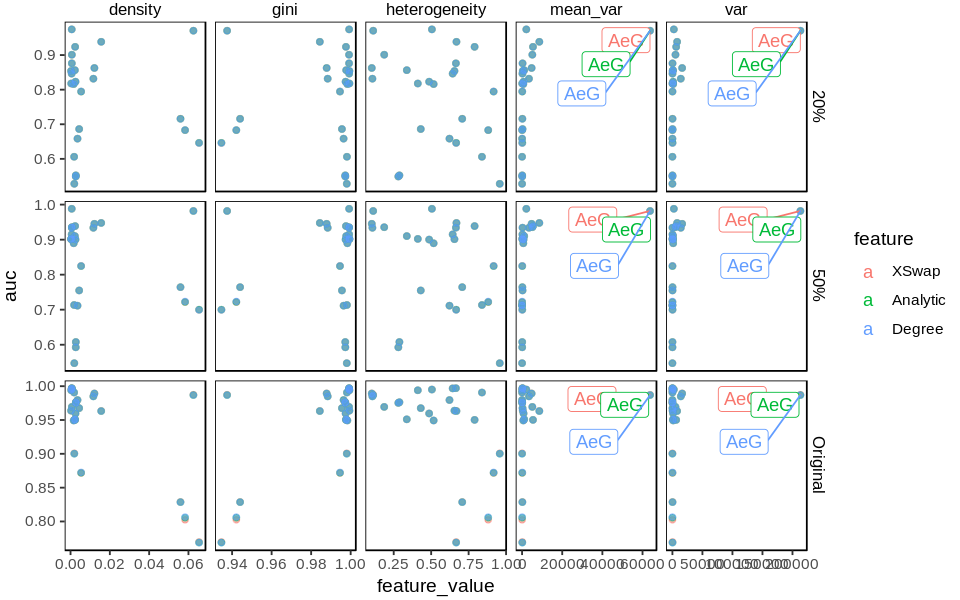

In [169]:
options(repr.plot.width=8, repr.plot.height=5)

(
    ggplot(vis_features, aes(x = feature_value, y = auc, color = feature))
    + geom_point(alpha = 0.5)
    + facet_grid(rows = vars(network), cols = vars(feature_name), scales = 'free')
    + geom_label_repel(data = vis_labels, aes(label = metaedge))
    + theme_zietzm()
)

In [269]:
full_auroc_df %>% head

metaedge,network,xswap_auc,analytic_auc,degree_product_auc,xswap_analytic_pearson,xswap_degree_pearson,analytic_degree_pearson,xswap_analytic_spearman,xswap_degree_spearman,analytic_degree_spearman,xswap_mae,analytic_mae,degree_mae
AdG,Original,0.9893888,0.9891555,0.9891437,0.9888247,0.9893140,0.9812317,0.9999947,0.9999937,0.9999998,0.016102612,0.015863588,1.241455e+03
AdG,Sample_50,0.9453517,0.9452759,0.9452496,0.9963539,0.9983290,0.9937833,0.9999994,0.9999992,0.9999998,0.009741119,0.009589568,2.635646e+06
AdG,Sample_20,0.8625895,0.8625841,0.8625734,0.9983635,0.9993225,0.9974224,0.9999999,0.9999999,0.9999999,0.010891597,0.010867070,1.077004e+07
GpPW,Original,0.9509656,0.9510125,0.9510227,0.9934010,0.9382767,0.9386158,0.9999661,0.9999681,0.9999985,0.004119021,0.004033436,1.865361e+02
GpPW,Sample_50,0.9101999,0.9101552,0.9101575,0.9963766,0.9817067,0.9799489,0.9999672,0.9999820,0.9999910,0.002113873,0.002097134,3.853850e+05
GpPW,Sample_20,0.8562783,0.8562770,0.8562720,0.9974587,0.9928761,0.9930251,0.9999589,0.9999774,0.9999892,0.002159841,0.002156392,1.429691e+06


In [285]:
full_auroc_df %>% filter(network == 'Original') %>% select(-network)

metaedge,xswap_auc,analytic_auc,degree_product_auc,xswap_analytic_pearson,xswap_degree_pearson,analytic_degree_pearson,xswap_analytic_spearman,xswap_degree_spearman,analytic_degree_spearman,xswap_mae,analytic_mae,degree_mae
AdG,0.9893888,0.9891555,0.9891437,0.9888247,0.9893140,0.9812317,0.9999947,0.9999937,0.9999998,0.0161026123,0.0158635883,1.241455e+03
GpPW,0.9509656,0.9510125,0.9510227,0.9934010,0.9382767,0.9386158,0.9999661,0.9999681,0.9999985,0.0041190211,0.0040334364,1.865361e+02
CtD,0.9794953,0.9795345,0.9795118,0.9926812,0.9724273,0.9715744,0.9999892,0.9999889,0.9999983,0.0063213255,0.0061857834,2.677355e+00
CcSE,0.9634935,0.9632011,0.9631950,0.9787225,0.9183494,0.9361001,0.9955539,0.9955158,0.9999996,0.0205717179,0.0210589890,2.169337e+03
GcG,0.9637774,0.9638410,0.9638769,0.9833755,0.9740009,0.9890968,0.9999785,0.9999844,0.9999862,0.0005435389,0.0005380972,3.469967e+01
CpD,0.9906288,0.9906524,0.9906487,0.9963277,0.9963014,0.9948226,0.9999981,0.9999985,0.9999996,0.0032939763,0.0032309981,7.135131e-01
AuG,0.9850810,0.9849000,0.9848888,0.9945396,0.9976309,0.9917708,0.9999975,0.9999972,0.9999998,0.0173794009,0.0166365845,1.137085e+03
CiPC,0.9007724,0.9001916,0.9002135,0.9966176,0.9957914,0.9990310,0.9994991,0.9995525,0.9999718,0.0037895184,0.0037779194,1.975594e+00
CCpG,0.9597105,0.9596712,0.9596800,0.9977175,0.9966213,0.9947623,0.9999409,0.9999554,0.9999899,0.0047597895,0.0046624618,1.857552e+02
DrD,0.8024732,0.8055626,0.8064201,0.9815636,0.9770166,0.9915530,0.9956131,0.9956068,0.9999331,0.0961083768,0.0932663191,6.277958e+01


In [299]:
correlations <- full_auroc_df %>%
    filter(network == 'Original') %>%
    summarise_at(vars(ends_with('mae'), ends_with('auc')), funs(mean)) %>%
    gather('temp_metric', 'value', ends_with('auc'), ends_with('mae')) %>%
    mutate(temp_metric = temp_metric %>% recode(degree_product_auc = 'degree_auc', 
                                                degree_product_mae = "degree_mae")) %>%
    separate("temp_metric", c("feature", "metric"), sep = "_", extra = "merge") %>%
    spread(metric, value)

correlations %>% head

feature,auc,mae
analytic,0.9464442,1.935735e-02
degree,0.9464984,1.682503e+03
xswap,0.9464312,1.923898e-02
